Tutorial: https://www.analyticsvidhya.com/blog/2021/05/sms-spam-detection-using-lstm-a-hands-on-guide/

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [43]:
data_path = "merged_cleaned_preprocessed.csv"      


df = pd.read_csv(data_path, encoding = "latin-1")
df.head()

,label,text
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts may...
3,0,u dun say early hor u c already say
4,0,nah think go usf life around though


In [44]:
df.shape

(35193, 2)

#Drop Null values:
Somehow it did not work to drop NULL values in preprocessing... Out of any reason there are some null falues in the data after reading the CSV even though they have not been there before writing the CSV file in the preprocessing skript!

In [45]:
df.isnull().sum()

label     0
text     14
dtype: int64

In [46]:
df.dropna(inplace=True)
df.isnull().sum()

label    0
text     0
dtype: int64

#Balancing Dataset: 

In [47]:
df_spam = df[df['label'] == 1]
df_ham  = df[df['label'] == 0]
print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)


Ham Dataset Shape: (20367, 2)
Spam Dataset Shape: (14812, 2)


In [48]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(14812, 2)

In [49]:
df = pd.concat([df_spam, df_ham_downsampled])

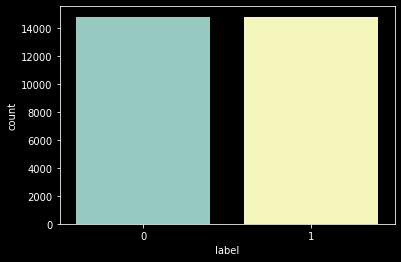

In [50]:
import seaborn as sns
sns.countplot(x=df["label"])

#Convert tokens into a numerical sequence:

In [52]:
X=df["text"]

tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X) # creating the numerical sequence

In [ ]:
#tokenizer.index_word

In [53]:
len(tokenizer.index_word)

131078

We do have 130427 unique words!

In [ ]:
#for i in range(3):
#        print("Text               : ",X[i] )
#        print("Numerical Sequence : ", text_to_sequence[i])

#Depending on the data this could fail since the index 0..2 could have been dropped in balancing the data! 

#Normalization:
Since all the messages are of different lengths also the sequences are of different length, so we have to padding the sequences with 0 to get equal length. Otherwise the sequences would not be compatible for the model!

In [54]:
max_length_sequence = max([len(i) for i in text_to_sequence]) # finding the length of largest sequence
padded_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, padding = "pre")
padded_sequence

array([[    0,     0,     0, ...,   140,    50,  1443],
       [    0,     0,     0, ..., 64869,   126, 50848],
       [    0,     0,     0, ...,   689,  1687,   139],
       ...,
       [    0,     0,     0, ...,  2790,    84,  4746],
       [    0,     0,     0, ...,  1666,   307,   353],
       [    0,     0,     0, ...,  4652,  2316,   210]], dtype=int32)

The longest Sentence exists of 501

In [55]:
print("shape",len(padded_sequence), "rows x ",len(padded_sequence[0]),"cols")

shape 29624 rows x  21227 cols


#Create LSTM Model:

In [56]:
TOT_SIZE = len(tokenizer.word_index)+1


def create_model():
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model


lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21227, 32)         4194528   
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                2020      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4,249,769
Trainable params: 4,249,769
No

#Train Test Validation Split

In [57]:
from sklearn.model_selection import train_test_split
X=padded_sequence
y=df["label"]
X_train, X_val,  y_train, y_val  = train_test_split(X, y, test_size=0.7, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_val, y_val, train_size=0.5)

#Train the model: 

In [58]:
from keras.callbacks import EarlyStopping

num_epochs = 10 #10!

history = lstm_model.fit(
               X_train ,
               y_train,
               epochs=num_epochs,
               validation_data=(X_val, y_val),
               #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
          )
#TIME: 48min 23s

Epoch 1/10
278/278 [==============================] - 278s 995ms/step - loss: 0.3187 - accuracy: 0.8813 - val_loss: 0.1210 - val_accuracy: 0.9546
Epoch 2/10
278/278 [==============================] - 277s 996ms/step - loss: 0.0607 - accuracy: 0.9814 - val_loss: 0.0885 - val_accuracy: 0.9683
Epoch 3/10
278/278 [==============================] - 280s 1s/step - loss: 0.0257 - accuracy: 0.9932 - val_loss: 0.1578 - val_accuracy: 0.9656
Epoch 4/10
278/278 [==============================] - 283s 1s/step - loss: 0.0209 - accuracy: 0.9957 - val_loss: 0.1374 - val_accuracy: 0.9537
Epoch 5/10
278/278 [==============================] - 331s 1s/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.1409 - val_accuracy: 0.9664
Epoch 6/10
278/278 [==============================] - 279s 1s/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1546 - val_accuracy: 0.9667
Epoch 7/10
278/278 [==============================] - 279s 1s/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.1583 - val_accuracy: 

#SAVE MODEL AS PICKLE FILE: 

In [59]:
import pickle
pickle.dump(lstm_model, open("lstm_model_merged_data.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://21a10584-8e4d-46b2-9c6f-bb285dd962b4/assets


INFO:tensorflow:Assets written to: ram://21a10584-8e4d-46b2-9c6f-bb285dd962b4/assets


#Evaluation: 

In [60]:
#scores = lstm_model.evaluate(X_test, y_test, verbose=0)
#print("Test Accuracy: %.2f%%" % (scores[1]*100))

In [61]:
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.flatten() 
y_pred = np.where(y_pred > 0.5, 1, 0) #Why? 

#y_test = y_test.to_numpy()
#Time: 1min 30s

Confusion Matrix: 

In [62]:
from sklearn.utils import check_matplotlib_support
from sklearn.utils.validation import check_memory
from sklearn.metrics import confusion_matrix, classification_report

In [63]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5149
           1       0.97      0.96      0.97      5220

    accuracy                           0.97     10369
   macro avg       0.97      0.97      0.97     10369
weighted avg       0.97      0.97      0.97     10369



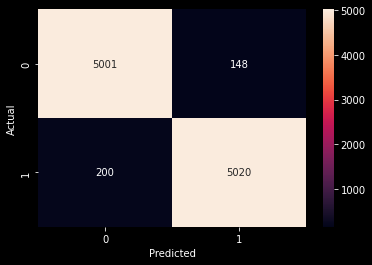

In [64]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm.png')
plt.show()

Loss:

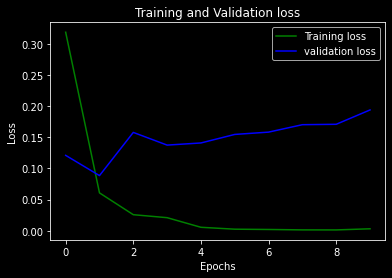

In [65]:
#epochs = range(1, num_epochs+1)
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

Accuracy: 

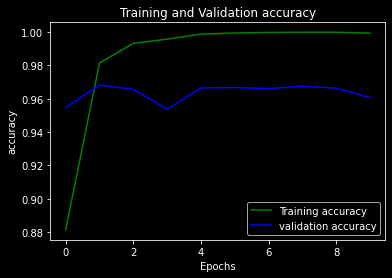

In [66]:
plt.plot( history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

Precission:

In [ ]:
print(history.history.keys())

In [ ]:
#FAILS since 'precision' is not stored in history anymore ?!
epochs = range(1, num_epochs+1)
plt.plot(history.history['precision'], 'g', label='Training precision')
plt.plot(history.history['val_precision'], 'b', label='validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.savefig('precission.png')
plt.show()